# 2D convolution network with SGD optimizer

In [48]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia/'
# path = '/home/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

['woodOnRed', 'blackOnRed', 'redOnRed', 'redOnRed_white', 'navyOnWhite', 'blackOnBlack', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'stainOnWhite', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed', 'greenOnGreen']
100800


In [49]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [50]:
print(immatrix.shape)

(100800, 4096)


In [51]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [52]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

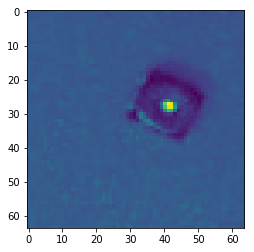

There are 1 dots, number is 4347


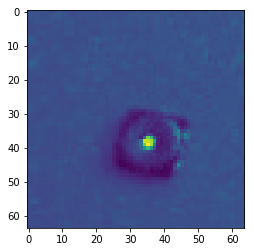

There are 1 dots, number is 3150


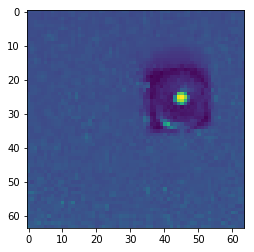

There are 1 dots, number is 3744


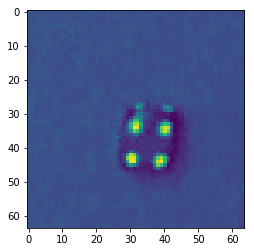

There are 4 dots, number is 8814


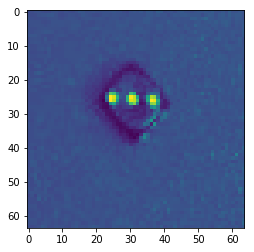

There are 3 dots, number is 6414


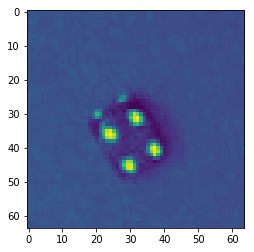

There are 4 dots, number is 8184


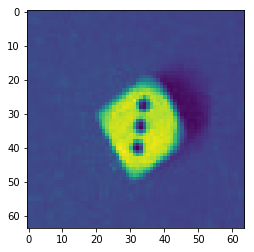

There are 3 dots, number is 1167


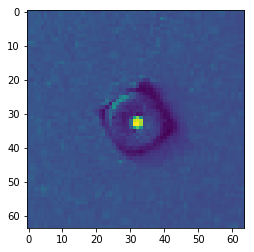

There are 1 dots, number is 4096


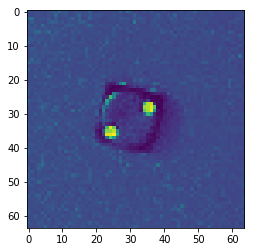

There are 2 dots, number is 5519


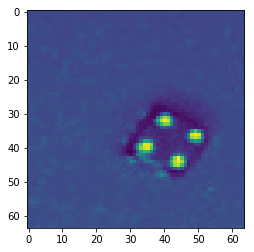

There are 4 dots, number is 8138


In [53]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 10080)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [54]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [55]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(80640, 1, 64, 64) (20160, 1, 64, 64)


In [56]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(80640, 6) (20160, 6)


In [57]:
# create sequential model with 2NN layers
def base_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(1, 64, 64), data_format='channels_first', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels_values, activation='softmax'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [58]:
# summarize model and apply checkpoints
model = base_model()
print(model.summary())
filepath = 'model2SGD-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 60, 60)        1664      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 30, 60)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 26, 32)        48032     
_________________________________________________________________
dropout_28 (Dropout)         (None, 28, 26, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 23296)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 784)               18264848  
_________________________________________________________________
dropout_29 (Dropout)         (None, 784)               0         
__________

In [59]:
# visualization of a model
plot_model(model, to_file='model2SGD_plot.png', show_shapes=True, show_layer_names=True)

In [60]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=2048, verbose=1, callbacks=callbacks_list)

Train on 80640 samples, validate on 20160 samples
Epoch 1/25
80640/80640 [==============================] - 37s 457us/step - loss: 1.7920 - acc: 0.1709 - val_loss: 1.7913 - val_acc: 0.1980
Epoch 2/25
80640/80640 [==============================] - 32s 395us/step - loss: 1.7909 - acc: 0.1856 - val_loss: 1.7903 - val_acc: 0.2000
Epoch 3/25
80640/80640 [==============================] - 32s 399us/step - loss: 1.7899 - acc: 0.1929 - val_loss: 1.7890 - val_acc: 0.2089
Epoch 4/25
80640/80640 [==============================] - 33s 403us/step - loss: 1.7886 - acc: 0.1978 - val_loss: 1.7878 - val_acc: 0.1931
Epoch 5/25
80640/80640 [==============================] - 32s 398us/step - loss: 1.7873 - acc: 0.2017 - val_loss: 1.7851 - val_acc: 0.2107
Epoch 6/25
80640/80640 [==============================] - 32s 400us/step - loss: 1.7846 - acc: 0.2084 - val_loss: 1.7806 - val_acc: 0.2188
Epoch 7/25
80640/80640 [==============================] - 32s 398us/step - loss: 1.7790 - acc: 0.2122 - val_loss: 1.

In [61]:
score = model.evaluate(X_test, y_test, verbose=1)

20160/20160 [==============================] - 4s 206us/step


In [62]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])
Accuracy: 36.92%
Test loss: 1.413705045079428
Test accuracy 0.3691964285714286


In [63]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 1.413705045079428
acc: 0.3691964285714286


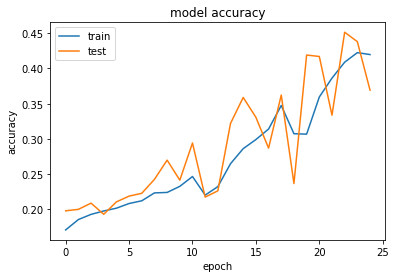

In [64]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

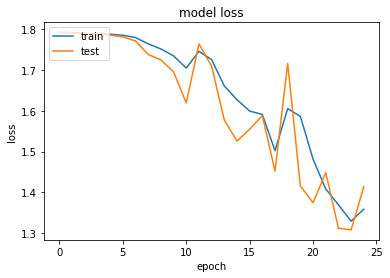

In [65]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
model_json = model.to_json()
with open('model2SGD_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2SGD_weights.h5')
print('Saved model weights')

Saved model weights


In [68]:
new_model = load_model('model2SGD-24-1.3296.h5')

In [69]:
filepath = 'model2SGD_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

Epoch 1/10


In [ ]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))


In [ ]:
model_json = model.to_json()
with open('model2SGD_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2SGD_weights_continue.h5')
print('Saved model weights')